# TQIP In-Hospital Model

This notebook illustrates how we trained the In-Hospital Model for the paper: "Assesing the Utility of Deep Neural Networks in Dynamic Risk Prediction After Trauma"

The TQIP database can be requested through the American College of Surgeons website at
https://facs.org

Before running this notebook, the TQIP data should be preprocessed. An example notebook can be found [here](https://github.com/alexbonde/TQIP/blob/main/TQIP_data_preprocessing.ipynb).



## Notebook set-up

Import pre-installed packages:

In [ ]:
import shap
import torch
import pickle
import random
import fastai
import joblib
import sklearn
import numpy as np
import pandas as pd
from math import sqrt
from pathlib import Path
import matplotlib.pyplot as pl
from fastai.tabular.all import *
from collections import OrderedDict
from platform import python_version 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import auc, roc_curve, roc_auc_score, brier_score_loss

Package versions: 

In [ ]:
print("SHAP version: " + shap.__version__)
print("Python version: " + python_version())
print("Pandas version: " + pd.__version__)
print("Pytorch version: " + torch.__version__)
print("Fastai version: " + fastai.__version__)
print("Sklearn version: " + sklearn.__version__)

SHAP version: 0.35.0
Python version: 3.8.3
Pandas version: 1.1.4
Pytorch version: 1.6.0
Fastai version: 2.0.11
Sklearn version: 0.23.1


Set seed for reproducable results:

In [ ]:
seed = 42

# python RNG
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

Disable warnings for chained assignments:

In [ ]:
pd.options.mode.chained_assignment=None

Path to the data folder:

In [ ]:
data = Path('E:\Data\TQIP')

## Load and preprocess data

Load processed train_val and test dataframes: 

In [ ]:
to = pickle.load(open('to_inhosp.pkl', 'rb'))

In [ ]:
to_test = pickle.load(open('to_inhosp_test.pkl', 'rb'))

## Random Forests

Function that creates random forests: 

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

The following function allows us to calculate 95% confidence intervals for the ROC AUC:<br>
* *Published by Shuntaro Ohno (https://github.com/doraneko94)*

In [ ]:
def roc_auc_ci(y_true, y_score, positive=1):
    AUC = roc_auc_score(y_true, y_score)
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, AUC, upper)

Function that calculated feature importance:

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

Create a loop that for each of the dependent variables: traines a random forest classifier, calculates performance metrics on the validation- and test sets, and calculates feature importance:  

In [ ]:
for i in to.ys.columns:
    m = rf(to.train.xs, to.train.ys[i]);
    print(i + ' Model:')
    l,AUC,h = roc_auc_ci(to.valid.ys[i], m.predict(to.valid.xs))
    b = brier_score_loss(to.valid.ys[i], m.predict(to.valid.xs))
    print ('Valid: roc_auc =', "%.3f" % AUC, '[',"%.3f" % l, ',', "%.3f" % h, '] Brier score =', 
          "%.5f" % b)
    l,AUC,h = roc_auc_ci(to_test.ys[i], m.predict(to_test.xs))
    b = brier_score_loss(to_test.ys[i], m.predict(to_test.xs))
    print ('Test: roc_auc =', "%.3f" % AUC, '[',"%.3f" % l, ',', "%.3f" % h, '] Brier score =', 
          "%.5f" % b)
    globals()['fi_%s' % i.replace(' ', '_')] = rf_feat_importance(m, to.train.xs)

Central Line-Associated Bloodstream Infection Model:
Valid: roc_auc = 0.688 [ 0.616 , 0.760 ] Brier score = 0.00036
Test: roc_auc = 0.783 [ 0.654 , 0.913 ] Brier score = 0.00026
Catheter-Associated Urinary Tract Infection Model:
Valid: roc_auc = 0.745 [ 0.716 , 0.774 ] Brier score = 0.00204
Test: roc_auc = 0.802 [ 0.752 , 0.852 ] Brier score = 0.00158
Superficial Incisional Surgical Site Infection Model:
Valid: roc_auc = 0.656 [ 0.602 , 0.709 ] Brier score = 0.00068
Test: roc_auc = 0.761 [ 0.679 , 0.843 ] Brier score = 0.00061
Deep Surgical Site Infection Model:
Valid: roc_auc = 0.773 [ 0.731 , 0.815 ] Brier score = 0.00092
Test: roc_auc = 0.769 [ 0.691 , 0.847 ] Brier score = 0.00064
Organspace Surgical Site Infection Model:
Valid: roc_auc = 0.795 [ 0.750 , 0.840 ] Brier score = 0.00075
Test: roc_auc = 0.783 [ 0.702 , 0.864 ] Brier score = 0.00059
Ventilator-Associated Pneumonia Model:
Valid: roc_auc = 0.897 [ 0.882 , 0.913 ] Brier score = 0.00378
Test: roc_auc = 0.929 [ 0.907 , 0.951

Save feature importances:

In [ ]:
pickle_subdir = Path('./pickle')
rf_fi_subdir = Path('./rf_fi')

In [ ]:
for i in to.ys.columns:
    picknm="fi_" + i +"_Inhospital_RF.p"
    picknm=picknm.replace(' ', '_')
    var = globals()['fi_%s' % i.replace(' ', '_')]
    pickle.dump(var, open(pickle_subdir/picknm, "wb" ) )

### Model Interpretation - Feature Importance

Plot and save feature importances: 

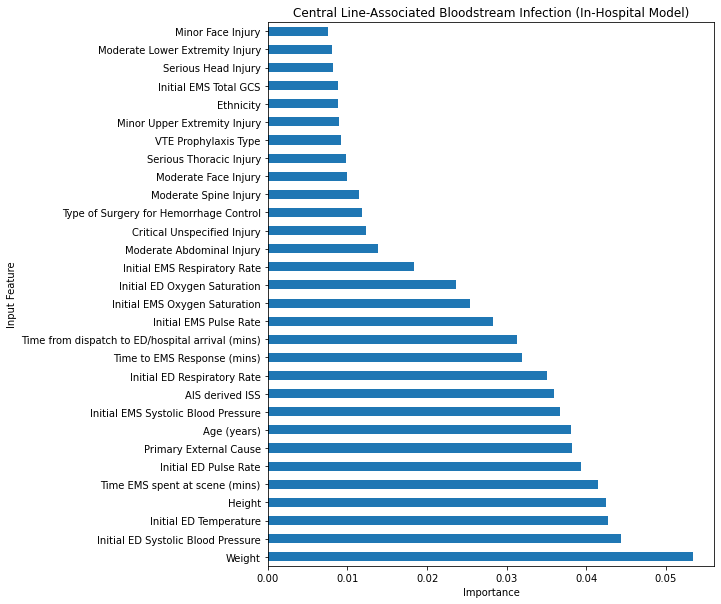

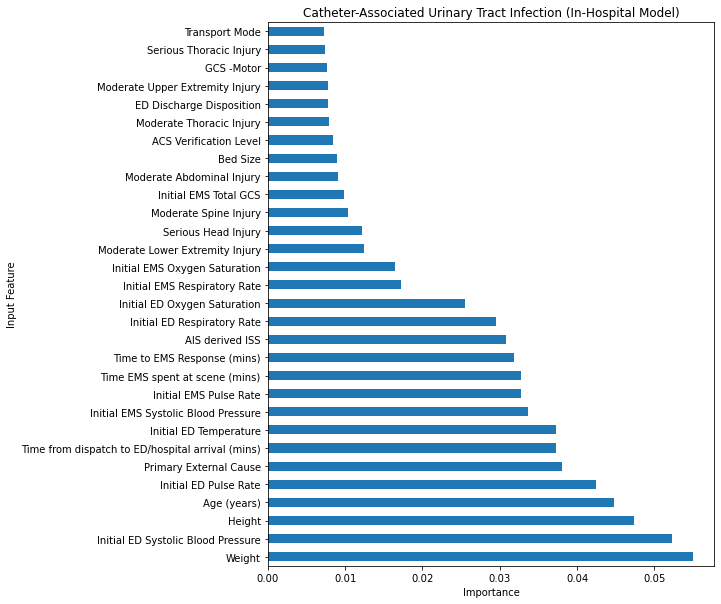

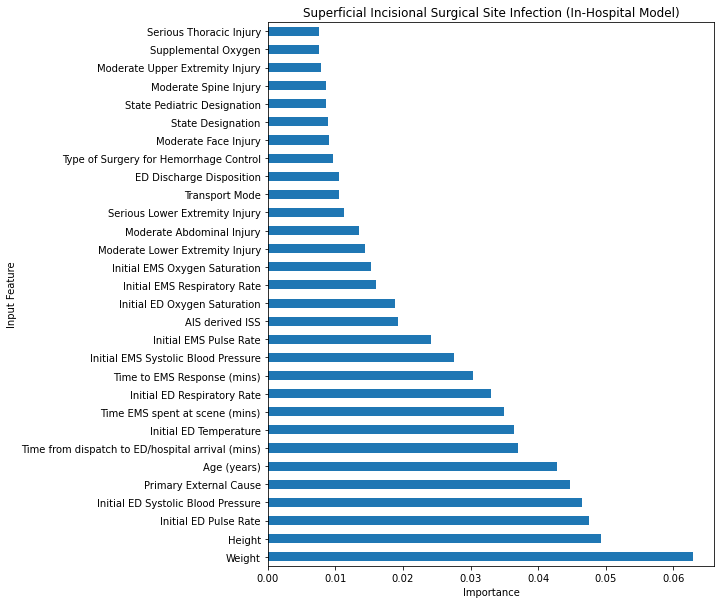

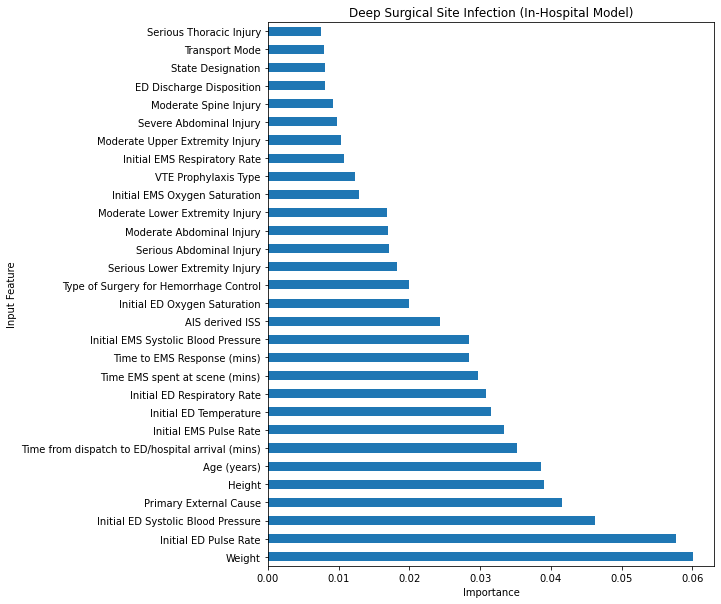

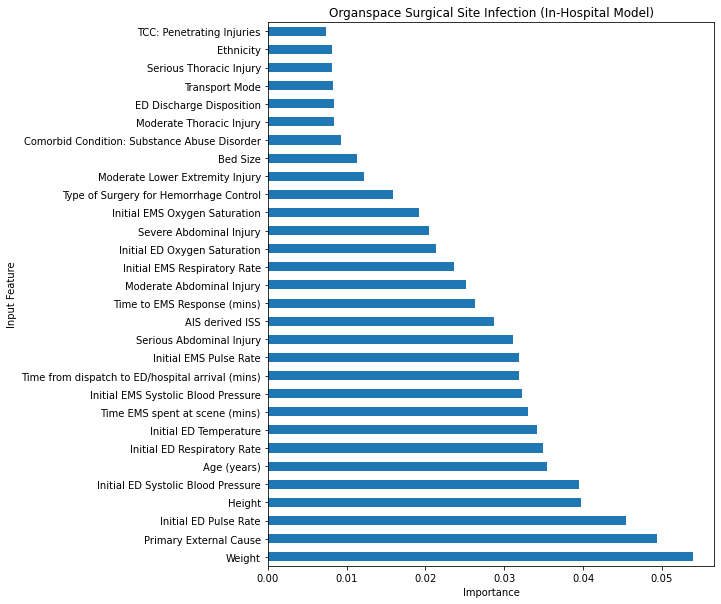

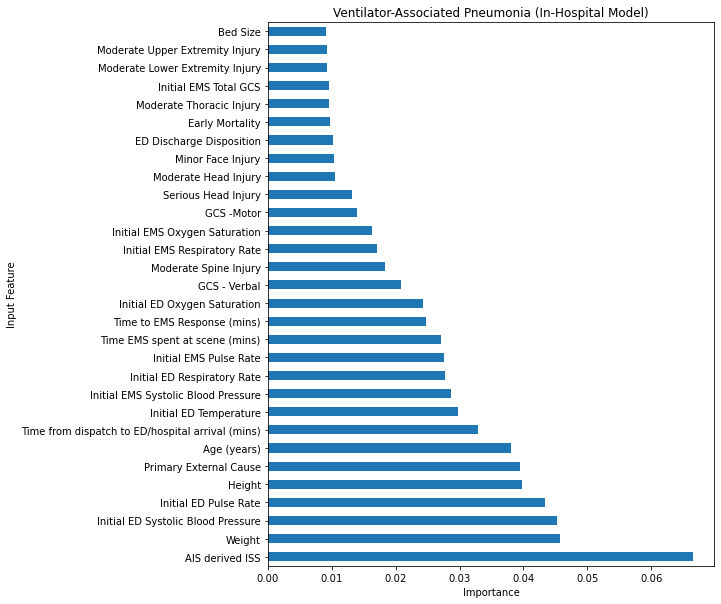

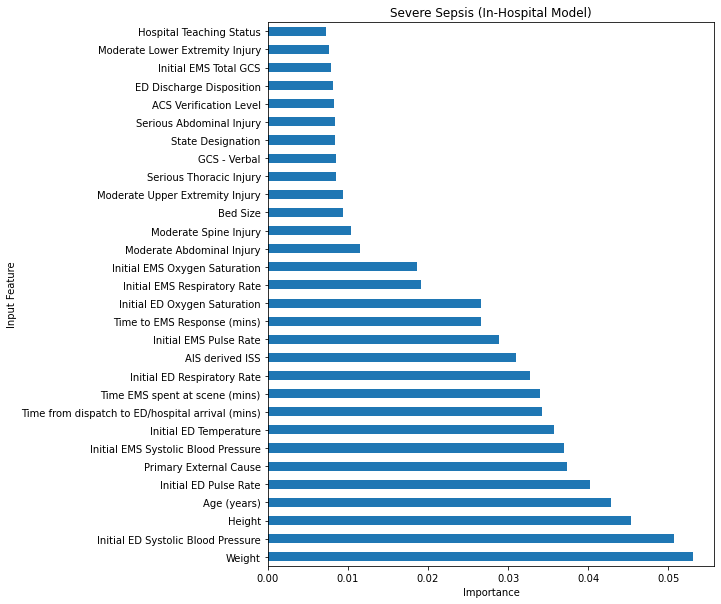

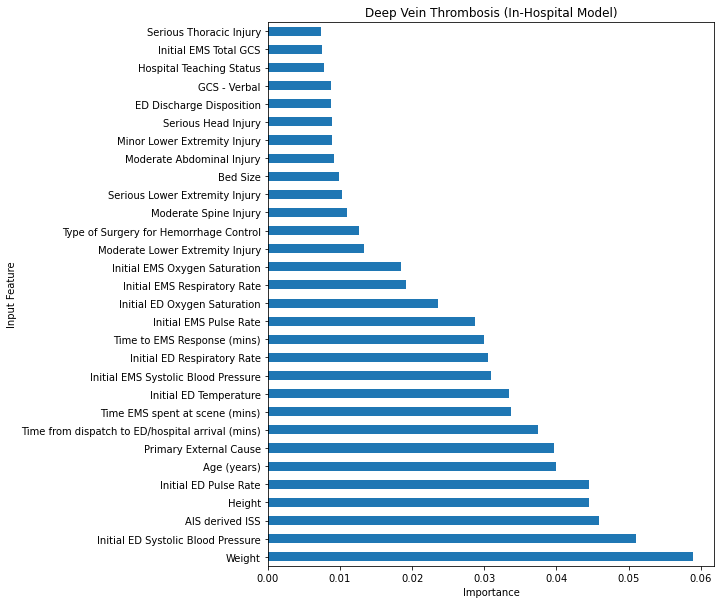

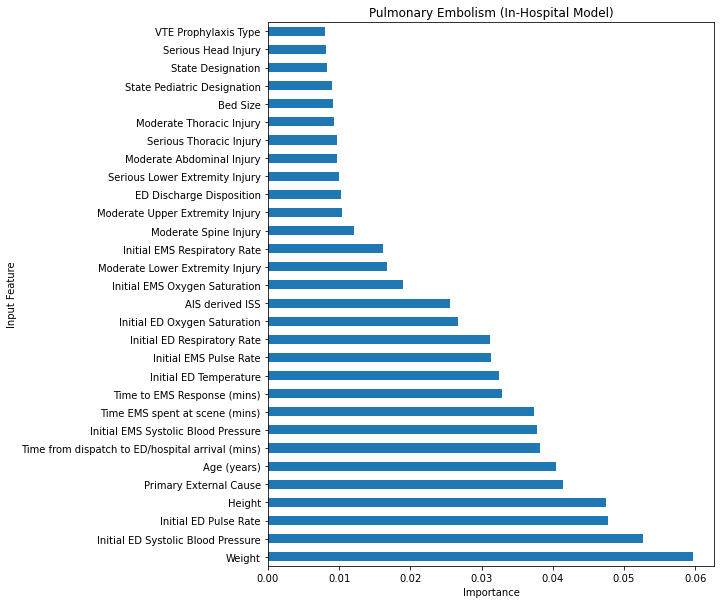

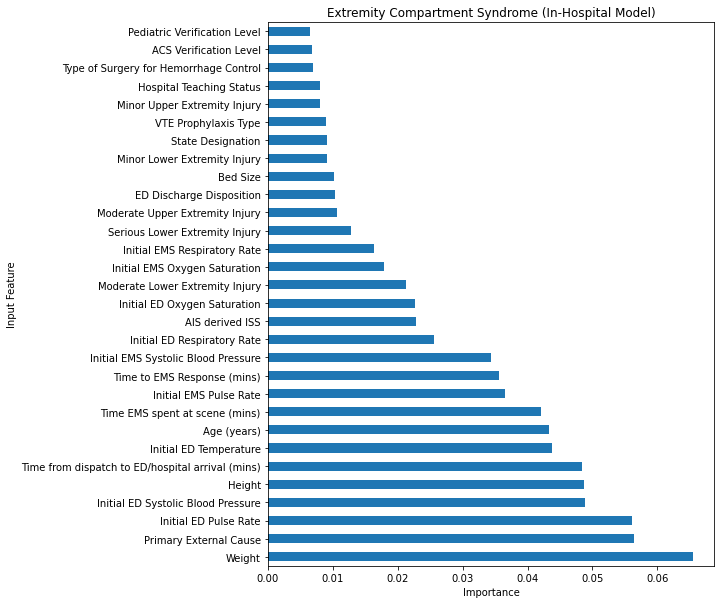

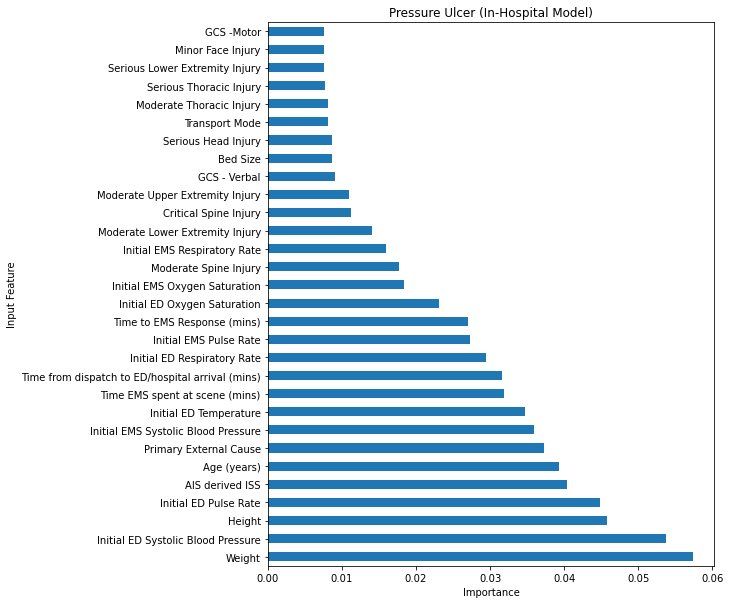

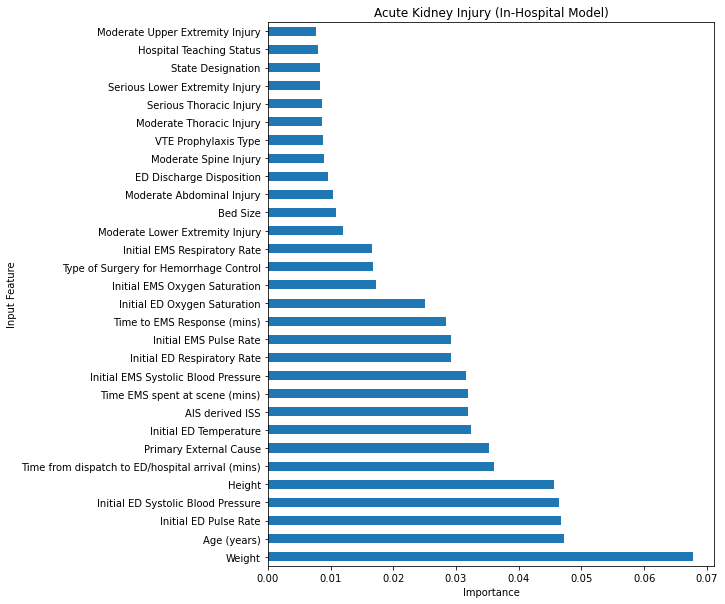

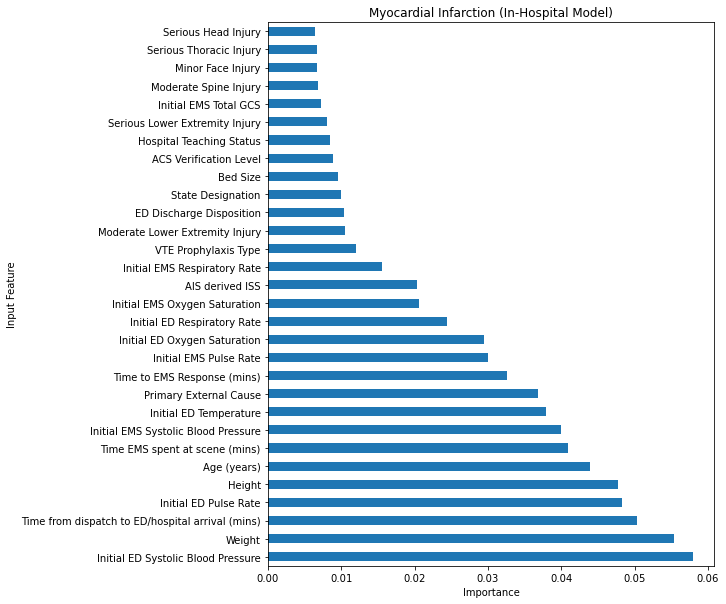

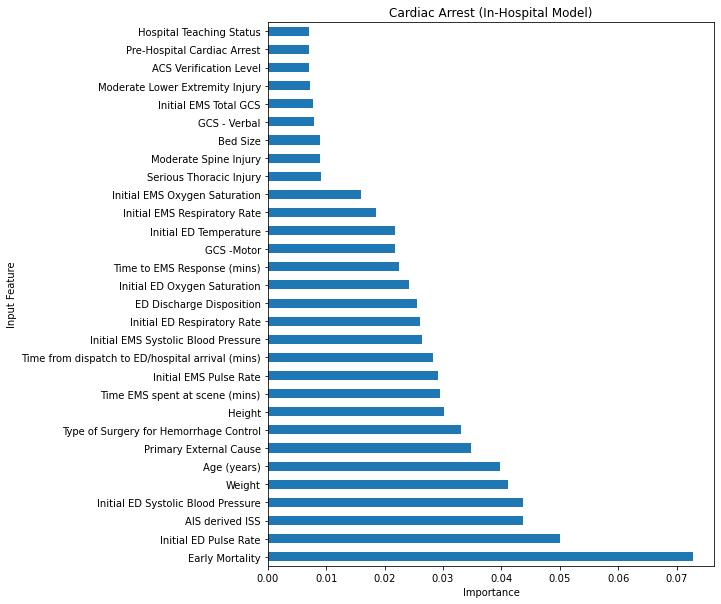

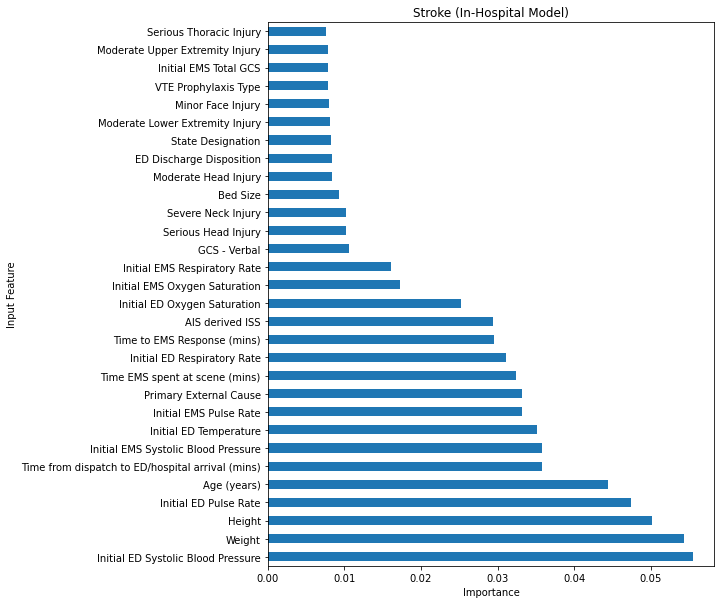

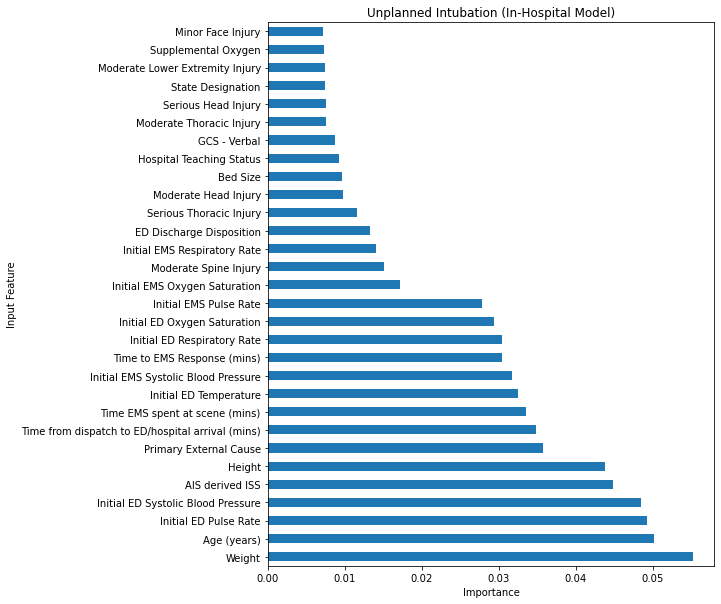

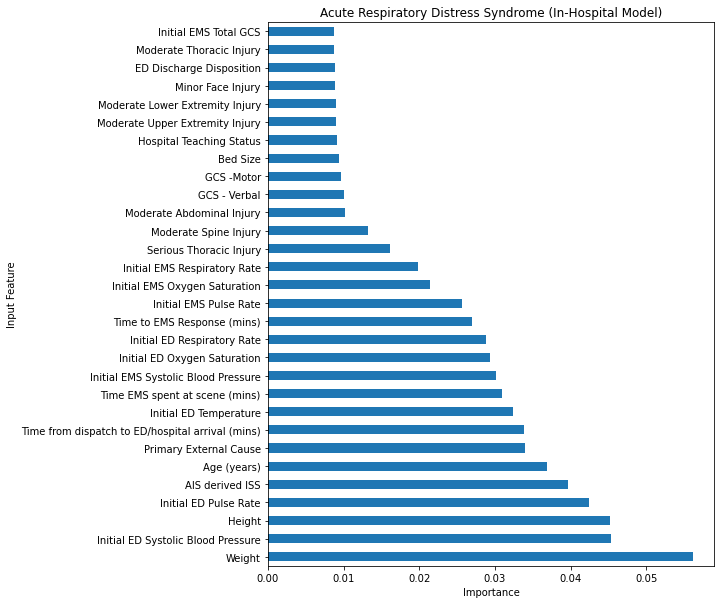

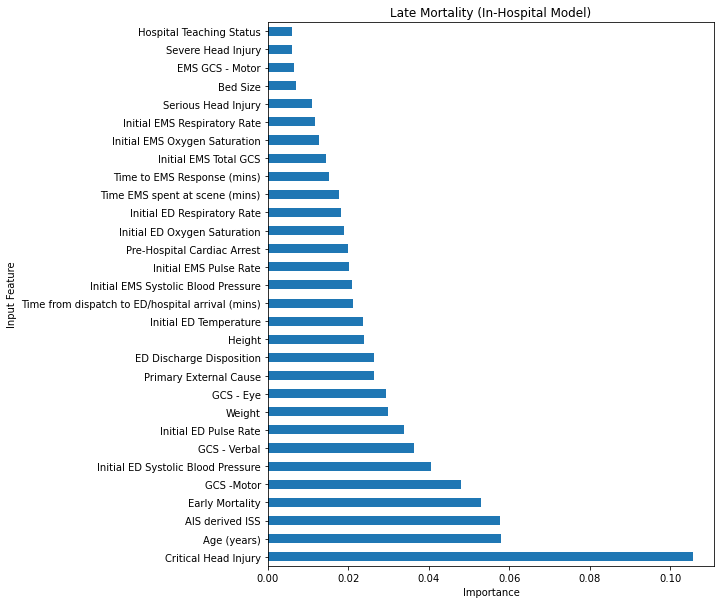

In [ ]:
for i in to.ys.columns:
    picknm="fi_" + i +"_Inhospital_RF.p"
    picknm=picknm.replace(' ', '_').replace('/', '_')
    title= i.replace('/', '_') + ' (In-Hospital Model)'
    fi = pickle.load( open(pickle_subdir/picknm, "rb" ) )
    fi.cols = fi.cols.str.replace('_na', ' - Missing')
    fig = fi[:30].plot('cols', 'imp', 'barh', figsize=(8,10), legend=False, title=title)
    fig.set_xlabel("Importance")
    fig.set_ylabel("Input Feature")
    fig.figure.savefig(rf_fi_subdir/title, bbox_inches='tight')

## Neural networks

Create dataloaders with a batchsize of 1024: 

In [ ]:
dls = to.dataloaders(1024, num_workers=0)

We chose the following hyperparameters: 
* *Two hidden layers with 1000 and 500 nodes respectively (layers=[1000,500])*<br>
* *A dropout on the first hidden layer of 0.1% and a dropout on the second layer of 1% (ps=[0.001,0.01])*<br>
* *A dropout on the embedding layers of 4% (embed_p=0.04)*<br>

The number of outpus are 19 (one for each of the dependent variables, n_out = 19)<br>
For performance metrics, we were interested in the average ROC AUC (RocAucMulti()), as well as the ROC AUC for each of the dependent variables (RocAucMulti(average=None)).

In [ ]:
learn = tabular_learner(dls, layers=[1000,500], 
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), metrics=[RocAucMulti(), RocAucMulti(average=None)])

Print a summary of the network:

In [ ]:
learn.summary()

TabularModel (Input shape: ['1024 x 147', '1024 x 17'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
________________________________________________________________
Embedding            1024 x 3             9          True      
__________________________________________

### Train- and save the model

We chose to train each model for 5 epochs, with a learning rate of 3e-3 and a weight decay (wd) of 0.2:

In [ ]:
learn.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.017385,0.017538,0.886395,[0.94450996 0.86163647 0.85764551 0.90617646 0.90182037 0.9440027 0.88810674 0.87307286 0.83046359 0.88373783 0.88341497 0.85380288 0.8347654 0.92900564 0.85916707 0.8637809 0.89468679 0.94531908],02:17
1,0.016765,0.016665,0.889494,[0.93584108 0.88020075 0.84156538 0.90589241 0.91840783 0.95375324 0.88416004 0.87470933 0.79856032 0.88820343 0.88855599 0.87359729 0.86584177 0.93003617 0.84656136 0.86935097 0.90435942 0.95128707],02:19
2,0.016584,0.016339,0.902130,[0.94755804 0.89692076 0.88065018 0.92236751 0.92192672 0.95623165 0.90025696 0.88375676 0.85716183 0.89411043 0.89984308 0.87899968 0.86753953 0.9321795 0.86265937 0.87966678 0.90484983 0.951669 ],02:21
3,0.016160,0.015993,0.908119,[0.94820101 0.89641133 0.86875273 0.92587676 0.93240071 0.95907911 0.9036265 0.89345701 0.8741442 0.91417046 0.90257621 0.88232955 0.87979772 0.93505327 0.88278151 0.88281556 0.91009017 0.95457966],02:20
4,0.015373,0.015966,0.908253,[0.95297095 0.89850206 0.8645176 0.92482947 0.92990696 0.95886409 0.90369834 0.89403236 0.87313512 0.91516828 0.90482019 0.88340771 0.88126763 0.9349671 0.87975112 0.88353242 0.91020631 0.95497562],02:20


Save and export the model:

In [ ]:
learn.save('TQIP_In-Hospital_Model')

Path('models/TQIP_In-Hospital_Model.pth')

In [ ]:
learn.export('models/TQIP_In-Hospital_Model.pkl')

### Performance metrics on the validation dataset

Load validation data:

In [ ]:
TQIP_val = pd.read_feather(data/'feather/2017_TQIP_val') 

Create a validation dataloader:

In [ ]:
dl = learn.dls.test_dl(TQIP_val)

Get the predictions for the validation dataset: 

In [ ]:
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)

Calculate ROC AUC's with 95% confidence intervals-, along with the Brier score, for each of the output variables:

In [ ]:
roc_values=[]
for i in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_val[(to.ys.columns[i])]), preds_tens[:, i], positive=1)
    roc_values.append(AUC)
    b = brier_score_loss((TQIP_val[(to.ys.columns[i])]), preds_tens[:, i])
    print(to.ys.columns[i] + ':', 'ROC_AUC =', "%.3f" % AUC, '[' + "%.3f" % l + ', ' + "%.3f" % h + '] - Brier score =', 
          "%.5f" % b)

Central Line-Associated Bloodstream Infection: ROC_AUC = 0.957 [0.925, 0.989] - Brier score = 0.00040
Catheter-Associated Urinary Tract Infection: ROC_AUC = 0.923 [0.904, 0.942] - Brier score = 0.00194
Superficial Incisional Surgical Site Infection: ROC_AUC = 0.932 [0.903, 0.961] - Brier score = 0.00076
Deep Surgical Site Infection: ROC_AUC = 0.958 [0.938, 0.979] - Brier score = 0.00093
Organspace Surgical Site Infection: ROC_AUC = 0.951 [0.923, 0.978] - Brier score = 0.00060
Ventilator-Associated Pneumonia: ROC_AUC = 0.973 [0.964, 0.981] - Brier score = 0.00365
Severe Sepsis: ROC_AUC = 0.928 [0.912, 0.944] - Brier score = 0.00251
Deep Vein Thrombosis: ROC_AUC = 0.908 [0.895, 0.921] - Brier score = 0.00463
Pulmonary Embolism: ROC_AUC = 0.901 [0.882, 0.919] - Brier score = 0.00250
Extremity Compartment Syndrome: ROC_AUC = 0.951 [0.923, 0.978] - Brier score = 0.00062
Pressure Ulcer: ROC_AUC = 0.936 [0.922, 0.951] - Brier score = 0.00272
Acute Kidney Injury: ROC_AUC = 0.910 [0.897, 0.924]

### Performance metrics on the test dataset

Load test data:

In [ ]:
TQIP_test = pd.read_feather(data/'feather/2017_TQIP_test') 

Create a test dataloader:

In [ ]:
dl = learn.dls.test_dl(TQIP_test)

Get the predictions for the test dataset: 

In [ ]:
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)

Calculate ROC AUC's with 95% confidence intervals-, along with the Brier score, for each of the output variables:

In [ ]:
roc_values=[]
for i in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test[(to.ys.columns[i])]), preds_tens[:, i], positive=1)
    roc_values.append(AUC)
    b = brier_score_loss((TQIP_test[(to.ys.columns[i])]), preds_tens[:, i])
    print(to.ys.columns[i] + ':', 'ROC_AUC =', "%.3f" % AUC, '[' + "%.3f" % l + ', ' + "%.3f" % h + '] - Brier score =', 
          "%.5f" % b)

Central Line-Associated Bloodstream Infection: ROC_AUC = 0.905 [0.809, 1.000] - Brier score = 0.00021
Catheter-Associated Urinary Tract Infection: ROC_AUC = 0.912 [0.875, 0.949] - Brier score = 0.00132
Superficial Incisional Surgical Site Infection: ROC_AUC = 0.885 [0.822, 0.949] - Brier score = 0.00055
Deep Surgical Site Infection: ROC_AUC = 0.923 [0.871, 0.974] - Brier score = 0.00060
Organspace Surgical Site Infection: ROC_AUC = 0.943 [0.896, 0.991] - Brier score = 0.00053
Ventilator-Associated Pneumonia: ROC_AUC = 0.967 [0.952, 0.983] - Brier score = 0.00293
Severe Sepsis: ROC_AUC = 0.924 [0.894, 0.954] - Brier score = 0.00178
Deep Vein Thrombosis: ROC_AUC = 0.910 [0.889, 0.930] - Brier score = 0.00418
Pulmonary Embolism: ROC_AUC = 0.915 [0.886, 0.943] - Brier score = 0.00212
Extremity Compartment Syndrome: ROC_AUC = 0.913 [0.863, 0.964] - Brier score = 0.00070
Pressure Ulcer: ROC_AUC = 0.915 [0.888, 0.943] - Brier score = 0.00234
Acute Kidney Injury: ROC_AUC = 0.894 [0.868, 0.920]

Calculate values for the ROC curves:

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
roc_values=[]

for i in range(len(to.ys.columns)):
    fpr[i], tpr[i], _ = roc_curve(TQIP_test[(to.ys.columns[i])], preds_tens[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    roc_values.append(roc_auc[i])
    
d=dict(list(enumerate(roc_values)))
dd = OrderedDict(sorted(d.items(), key=lambda x: x[1], reverse=True))
roc_ordered=dd.keys()

Create a list of colors for the ROC curves: 

In [ ]:
colors = ['gold', 'orange', 'darkgoldenrod', 'saddlebrown', 'olive', 'lightskyblue', 'mediumblue',
         'darkolivegreen', 'limegreen', 'darkgreen', 'wheat', 'darkcyan', 'orangered', 'lightseagreen', 'tomato', 
         'darkviolet', 'indigo', 'red', 'grey']

Plot the ROC curves with the AUC:

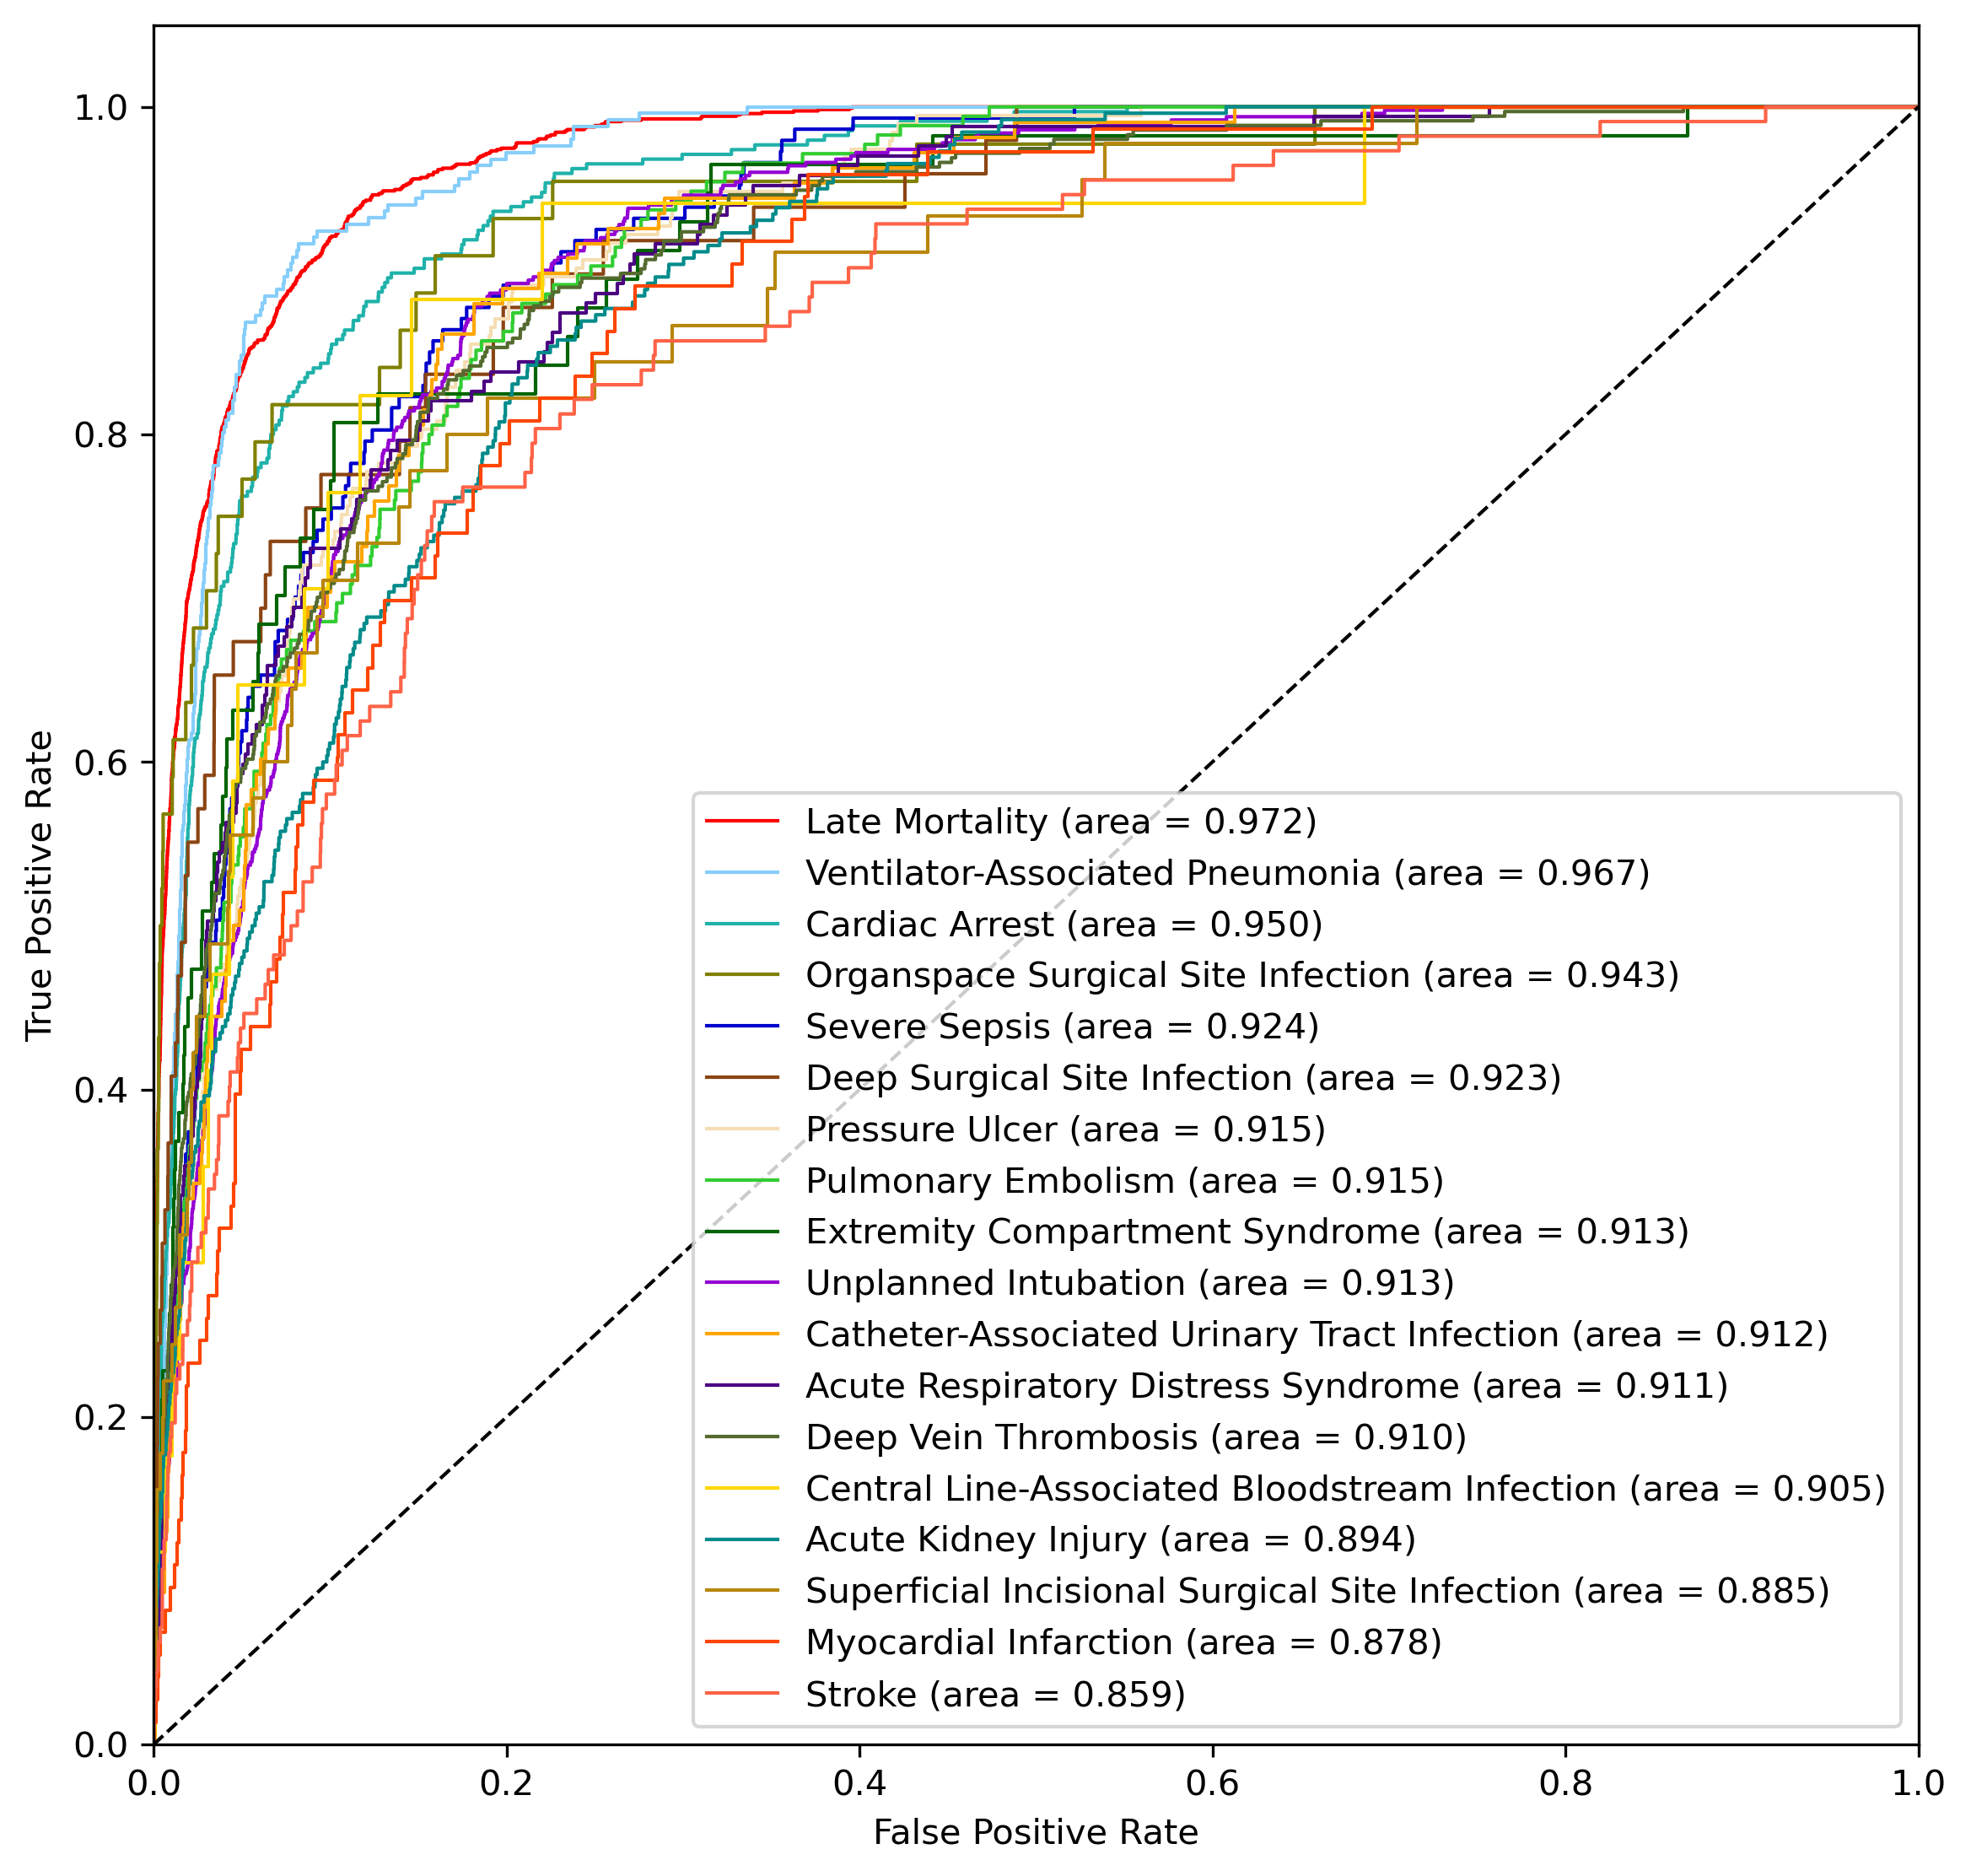

In [ ]:
plt.figure(num=None, figsize=(9, 9), dpi=300, facecolor='w', edgecolor='k')

for i in(roc_ordered):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=1,
    label=to.ys.columns[i]+' (area = {1:0.3f})'''.format(i, roc_auc[i]))
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.savefig('ROC_TQIP_In-Hospital_Model.jpg', bbox_inches='tight')

#### Race or gender disparities

Investigate wether the algorithm consolidates race or gender disparities: 

Race statistics in the test dataset: 

In [ ]:
race_cats = ['Race Category: Asian', 'Race Category: Pacific Islander', 'Race Category: Other', 
             'Race Category: American Indian', 'Race Category: Black', 'Race Category: White']

In [ ]:
for i in race_cats: 
    counts = len(TQIP_test.loc[TQIP_test[i]=='Yes'])
    perc = counts/len(TQIP_test)
    print(i, '- Count =', counts, '- Percentage =', "{:.1%}".format(perc))

Race Category: Asian - Count = 1366 - Percentage = 1.7%
Race Category: Pacific Islander - Count = 121 - Percentage = 0.1%
Race Category: Other - Count = 9452 - Percentage = 11.7%
Race Category: American Indian - Count = 530 - Percentage = 0.7%
Race Category: Black - Count = 16760 - Percentage = 20.7%
Race Category: White - Count = 51881 - Percentage = 64.0%


Performance metrics based on race (white vs. non-white):

White: 

In [ ]:
TQIP_test_white = TQIP_test.loc[TQIP_test['Race Category: White'] == 'Yes']
dl = learn.dls.test_dl(TQIP_test_white)
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)
roc_values=[]
for x in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test_white[(to.ys.columns[x])]), preds_tens[:, x], positive=1)
    roc_values.append(AUC)
    print ((to.ys.columns[x]), 'roc_auc =', "%.3f" % AUC, '['+"%.3f" % l +',', "%.3f" % h + ']')

Central Line-Associated Bloodstream Infection roc_auc = 0.920 [0.804, 1.000]
Catheter-Associated Urinary Tract Infection roc_auc = 0.909 [0.863, 0.956]
Superficial Incisional Surgical Site Infection roc_auc = 0.901 [0.821, 0.980]
Deep Surgical Site Infection roc_auc = 0.899 [0.827, 0.971]
Organspace Surgical Site Infection roc_auc = 0.940 [0.861, 1.000]
Ventilator-Associated Pneumonia roc_auc = 0.964 [0.944, 0.984]
Severe Sepsis roc_auc = 0.909 [0.866, 0.951]
Deep Vein Thrombosis roc_auc = 0.895 [0.868, 0.923]
Pulmonary Embolism roc_auc = 0.898 [0.859, 0.936]
Extremity Compartment Syndrome roc_auc = 0.896 [0.818, 0.974]
Pressure Ulcer roc_auc = 0.885 [0.848, 0.922]
Acute Kidney Injury roc_auc = 0.868 [0.834, 0.902]
Myocardial Infarction roc_auc = 0.853 [0.791, 0.915]
Cardiac Arrest roc_auc = 0.938 [0.915, 0.961]
Stroke roc_auc = 0.819 [0.761, 0.877]
Unplanned Intubation roc_auc = 0.903 [0.882, 0.923]
Acute Respiratory Distress Syndrome roc_auc = 0.901 [0.865, 0.937]
Late Mortality roc_

Non-white: 

In [ ]:
TQIP_test_nwhite = TQIP_test.loc[TQIP_test['Race Category: White'] == 'No']
dl = learn.dls.test_dl(TQIP_test_nwhite)
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)
roc_values=[]
for x in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test_nwhite[(to.ys.columns[x])]), preds_tens[:, x], positive=1)
    roc_values.append(AUC)
    print ((to.ys.columns[x]), 'roc_auc =', "%.3f" % AUC, '['+"%.3f" % l +',', "%.3f" % h + ']')

Central Line-Associated Bloodstream Infection roc_auc = 0.888 [0.728, 1.000]
Catheter-Associated Urinary Tract Infection roc_auc = 0.919 [0.858, 0.979]
Superficial Incisional Surgical Site Infection roc_auc = 0.865 [0.760, 0.969]
Deep Surgical Site Infection roc_auc = 0.965 [0.904, 1.000]
Organspace Surgical Site Infection roc_auc = 0.944 [0.883, 1.000]
Ventilator-Associated Pneumonia roc_auc = 0.974 [0.950, 0.998]
Severe Sepsis roc_auc = 0.945 [0.906, 0.985]
Deep Vein Thrombosis roc_auc = 0.932 [0.902, 0.963]
Pulmonary Embolism roc_auc = 0.940 [0.899, 0.981]
Extremity Compartment Syndrome roc_auc = 0.925 [0.858, 0.991]
Pressure Ulcer roc_auc = 0.963 [0.929, 0.996]
Acute Kidney Injury roc_auc = 0.936 [0.900, 0.972]
Myocardial Infarction roc_auc = 0.924 [0.834, 1.000]
Cardiac Arrest roc_auc = 0.965 [0.944, 0.985]
Stroke roc_auc = 0.933 [0.875, 0.990]
Unplanned Intubation roc_auc = 0.931 [0.901, 0.961]
Acute Respiratory Distress Syndrome roc_auc = 0.937 [0.888, 0.987]
Late Mortality roc_

Performance metrics based on gender (male vs female):

In [ ]:
TQIP_test.Gender.value_counts(normalize = True)

Male      0.630206
Female    0.369794
Name: Gender, dtype: float64

Male: 

In [ ]:
TQIP_test_male = TQIP_test.loc[TQIP_test['Gender'] == 'Male']
dl = learn.dls.test_dl(TQIP_test_male)
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)
roc_values=[]
for x in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test_male[(to.ys.columns[x])]), preds_tens[:, x], positive=1)
    roc_values.append(AUC)
    print ((to.ys.columns[x]), 'roc_auc =', "%.3f" % AUC, '['+"%.3f" % l +',', "%.3f" % h + ']')

Central Line-Associated Bloodstream Infection roc_auc = 0.932 [0.833, 1.000]
Catheter-Associated Urinary Tract Infection roc_auc = 0.918 [0.860, 0.975]
Superficial Incisional Surgical Site Infection roc_auc = 0.879 [0.800, 0.957]
Deep Surgical Site Infection roc_auc = 0.953 [0.902, 1.000]
Organspace Surgical Site Infection roc_auc = 0.942 [0.887, 0.998]
Ventilator-Associated Pneumonia roc_auc = 0.962 [0.943, 0.980]
Severe Sepsis roc_auc = 0.926 [0.891, 0.962]
Deep Vein Thrombosis roc_auc = 0.922 [0.899, 0.944]
Pulmonary Embolism roc_auc = 0.932 [0.902, 0.963]
Extremity Compartment Syndrome roc_auc = 0.936 [0.888, 0.984]
Pressure Ulcer roc_auc = 0.919 [0.886, 0.952]
Acute Kidney Injury roc_auc = 0.905 [0.875, 0.935]
Myocardial Infarction roc_auc = 0.891 [0.823, 0.959]
Cardiac Arrest roc_auc = 0.956 [0.938, 0.974]
Stroke roc_auc = 0.888 [0.838, 0.939]
Unplanned Intubation roc_auc = 0.922 [0.902, 0.941]
Acute Respiratory Distress Syndrome roc_auc = 0.926 [0.893, 0.958]
Late Mortality roc_

Female: 

In [ ]:
TQIP_test_female = TQIP_test.loc[TQIP_test['Gender'] == 'Female']
dl = learn.dls.test_dl(TQIP_test_female)
preds_tens, ys = learn.get_preds(dl=dl, n_workers=0)
roc_values=[]
for x in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test_female[(to.ys.columns[x])]), preds_tens[:, x], positive=1)
    roc_values.append(AUC)
    print ((to.ys.columns[x]), 'roc_auc =', "%.3f" % AUC, '['+"%.3f" % l +',', "%.3f" % h + ']')

Central Line-Associated Bloodstream Infection roc_auc = 0.829 [0.607, 1.000]
Catheter-Associated Urinary Tract Infection roc_auc = 0.896 [0.845, 0.947]
Superficial Incisional Surgical Site Infection roc_auc = 0.890 [0.777, 1.000]
Deep Surgical Site Infection roc_auc = 0.869 [0.759, 0.978]
Organspace Surgical Site Infection roc_auc = 0.942 [0.846, 1.000]
Ventilator-Associated Pneumonia roc_auc = 0.977 [0.948, 1.000]
Severe Sepsis roc_auc = 0.916 [0.863, 0.970]
Deep Vein Thrombosis roc_auc = 0.873 [0.828, 0.919]
Pulmonary Embolism roc_auc = 0.864 [0.799, 0.928]
Extremity Compartment Syndrome roc_auc = 0.743 [0.545, 0.941]
Pressure Ulcer roc_auc = 0.910 [0.864, 0.957]
Acute Kidney Injury roc_auc = 0.869 [0.820, 0.917]
Myocardial Infarction roc_auc = 0.849 [0.769, 0.930]
Cardiac Arrest roc_auc = 0.932 [0.897, 0.967]
Stroke roc_auc = 0.806 [0.726, 0.886]
Unplanned Intubation roc_auc = 0.891 [0.858, 0.924]
Acute Respiratory Distress Syndrome roc_auc = 0.870 [0.804, 0.935]
Late Mortality roc_

### Model interpretation - Shapley Additive Explanations

Define functions for integrating SHAP with fastai:
* *Published by Zachary Mueller, (https://github.com/muellerzr)*

In [ ]:
def _prepare_data(learn:Learner, test_data=None, n_samples:int=128):
    "Prepares train and test data for `SHAP`, pass in a learner with optional data"
    no_user_provided_test_data = test_data is None
    if isinstance(test_data, pd.DataFrame):
        dl = learn.dls.test_dl(test_data)
    elif isinstance(test_data, TabDataLoader):
        dl = test_data
    elif test_data is None:
        try:
            dl = learn.dls[1]
        except IndexError:
            print('No validation dataloader, using `train`')
            dl = learn.dls[0]
    else:
        raise ValueError('Input is not supported. Please use either a `DataFrame` or `TabularDataLoader`')
    test_data = pd.merge(dl.cats, dl.conts, left_index=True, right_index=True)
    return test_data.sample(n=n_samples) if ((len(test_data) > n_samples) and no_user_provided_test_data) else test_data

def _predict(learn:TabularLearner, data:np.array):
    "Predict function for some data on a fastai model"
    device = 'cpu'
    model = learn.model.to(device)
    dl = learn.dls[0]
    nb_cat_cols = len(dl.dataset.cat_names)
    nb_cont_cols = len(dl.dataset.cont_names)
    x_cat = torch.from_numpy(data[:, :nb_cat_cols]).to(device, torch.int64)
    x_cont = torch.from_numpy(data[:, -nb_cont_cols:]).to(device, torch.float32)
    with torch.no_grad():
        pred_probs = learn.model(x_cat, x_cont).cpu().numpy()
    return pred_probs

class ShapInterpretation():
    "Base interpereter to use the `SHAP` interpretation library"
    def __init__(self, learn:TabularLearner, test_data=None, link='identity', l1_reg='auto', n_samples=128, **kwargs):
        "Initialize `ShapInterpretation` with a Learner, test_data, link, `n_samples`, `l1_reg`, and optional **kwargs"
        self.model = learn.model
        self.dls = learn.dls
        self.class_names = learn.dls.vocab if hasattr(learn.dls, 'vocab') else None # only defined for classification problems
        self.train_data = pd.merge(learn.dls.cats, learn.dls.conts, left_index=True, right_index=True)
        self.test_data = _prepare_data(learn, test_data, n_samples)
        pred_func = partial(_predict, learn)
        self.explainer = shap.SamplingExplainer(pred_func, self.train_data, **kwargs)
        self.shap_vals = self.explainer.shap_values(self.test_data, l1_reg=l1_reg)
        self.is_multi_output = isinstance(self.shap_vals, list)

Create a dataset of 10,000 randomly selected patients from the test data:

In [ ]:
test_sample = TQIP_test.sample(10000, random_state=seed)

Calculate SHAP values for the test sample:

In [ ]:
TQIP_shap = ShapInterpretation(learn, test_sample)

Save the explainer: 

In [ ]:
joblib.dump(TQIP_shap.explainer, filename='explainers/inhosp_explainer.bz2', compress=('bz2', 9))

['inhosp_explainer.bz2']

Save the SHAP values as a pickle file:

In [ ]:
pickle.dump(TQIP_shap, open( "TQIP_Inhospital_shap.p", "wb" ) )

Load the shap values:

In [ ]:
TQIP_shap = pickle.load( open( "TQIP_Inhospital_shap.p", "rb" ) )

Rename output features for the plot:

In [ ]:
class_names=['CLABSI', 'CAUTI', 'Superficial Incisional SSI', 'Deep SSI', 'Organ-Space SSI', 'Ventilator-Associated Pneumonia',
             'Severe Sepsis', 'Deep Vein Thrombosis', 'Pulmonary Embolism', 'Extremity Compartment Syndrome', 'Pressure Ulcer', 
             'Acute Kidney Injury', 'Myocardial Infarction', 'Cardiac Arrest', 'Stroke', 'Unplanned Intubation',
             'Acute Respiratory Distress Syndrome', 'Late Mortality'] 

Plot and save a SHAP summary plot: 

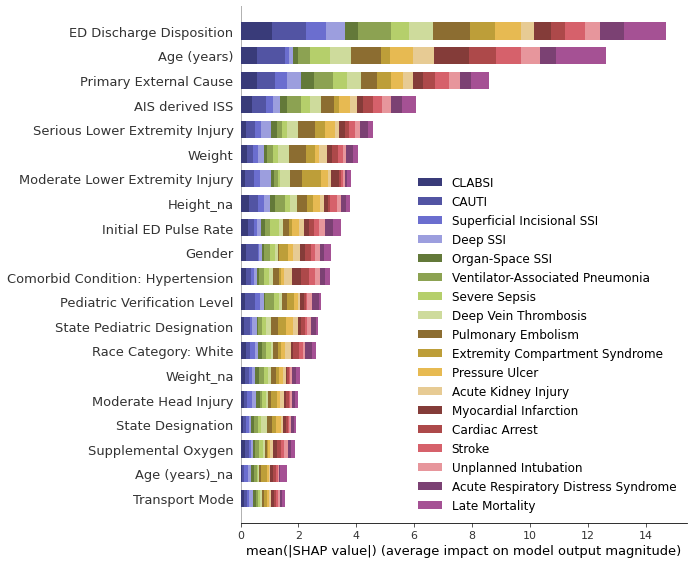

In [ ]:
shap.summary_plot(TQIP_shap.shap_vals, TQIP_shap.test_data, color=pl.get_cmap('tab20b'), class_names = class_names, 
                  class_inds = list(range(0, 18)), show = False)
pl.savefig("summary_plot_In-Hospital.jpg", bbox_inches='tight')

The importance of race categories:

In [ ]:
for i in to.ys.columns:
    picknm="fi_" + i +"_Inhospital_RF.p"
    picknm=picknm.replace(' ', '_').replace('/', '_')
    title= i.replace('/', '_') + ' (In-Hospital Model)'
    fi = pickle.load( open(pickle_subdir/picknm, "rb" ) )
    print(i)
    for x in race_cats:
        fi = fi.reset_index(drop=True)
        print(fi.loc[fi.cols == x])

Central Line-Associated Bloodstream Infection
                    cols       imp
82  Race Category: Asian  0.002063
                                cols  imp
150  Race Category: Pacific Islander  0.0
                    cols       imp
51  Race Category: Other  0.004046
                               cols     imp
139  Race Category: American Indian  0.0002
                    cols       imp
48  Race Category: Black  0.004383
                    cols       imp
86  Race Category: White  0.001899
Catheter-Associated Urinary Tract Infection
                     cols       imp
106  Race Category: Asian  0.001067
                                cols       imp
141  Race Category: Pacific Islander  0.000276
                    cols       imp
66  Race Category: Other  0.003301
                               cols       imp
111  Race Category: American Indian  0.000904
                    cols       imp
86  Race Category: Black  0.001891
                    cols       imp
74  Race Category: White 

#### Model Performance without early mortality and ED discharge disposition

Load the processed train_val dataframe: 

In [ ]:
to_noearlymort = pickle.load(open('to_inhosp_noearlymort.pkl', 'rb'))

In [ ]:
dls_noearlymort = to_noearlymort.dataloaders(1024, num_workers=0)

In [ ]:
learn_noearlymort = tabular_learner(dls_noearlymort, layers=[1000,500], 
                        config=tabular_config(ps=[0.001,0.01], embed_p=0.04), metrics=[RocAucMulti(), RocAucMulti(average=None)])

In [ ]:
learn_noearlymort.fit_one_cycle(5, 3e-3, wd=0.2)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.018404,0.018382,0.860980,[0.91850712 0.83913162 0.80011553 0.86444168 0.88687313 0.9347797 0.84410695 0.83789488 0.77807237 0.77698164 0.85705404 0.83356297 0.84934983 0.90534373 0.81760345 0.83262131 0.86751469 0.98410493 0.93055191],01:05
1,0.018379,0.017716,0.868093,[0.92651466 0.86091387 0.76859905 0.87765701 0.88900856 0.93949026 0.85778145 0.85325057 0.7878243 0.78255349 0.85597134 0.83451774 0.84695409 0.91515566 0.85229425 0.84972737 0.87202547 0.98855851 0.93497249],01:05
2,0.017111,0.017358,0.883156,[0.94073502 0.87484767 0.81374221 0.88300211 0.90142343 0.94541338 0.87421615 0.86617173 0.8303007 0.80286603 0.87946603 0.85048032 0.86911395 0.92028328 0.84534918 0.85913797 0.89475603 0.99050935 0.93815724],01:04
3,0.017083,0.017057,0.888345,[0.94274491 0.88163236 0.81032753 0.89174594 0.90122236 0.94706472 0.88200126 0.86985132 0.83344747 0.81152839 0.88476809 0.86272414 0.87661501 0.92238003 0.86516842 0.86499235 0.89750017 0.99144553 0.94138792],01:03
4,0.016335,0.017009,0.889200,[0.94465342 0.87900655 0.81669861 0.89433883 0.89899616 0.94747739 0.88414591 0.86945895 0.83645383 0.81690305 0.88601737 0.8635577 0.87338341 0.92254167 0.86083571 0.86651042 0.90035162 0.99174737 0.94172071],01:04


In [ ]:
dl_noearlymort = learn_noearlymort.dls.test_dl(TQIP_test)

Get the predictions for the test dataset: 

In [ ]:
preds_tens, ys = learn_noearlymort.get_preds(dl=dl_noearlymort, n_workers=0)

Calculate ROC AUC's with 95% confidence intervals-, along with the Brier score, for each of the output variables:

In [ ]:
roc_values=[]
for i in range(len(to.ys.columns)):
    l,AUC,h = roc_auc_ci((TQIP_test[(to.ys.columns[i])]), preds_tens[:, i], positive=1)
    roc_values.append(AUC)
    b = brier_score_loss((TQIP_test[(to.ys.columns[i])]), preds_tens[:, i])
    print(to.ys.columns[i] + ':', 'ROC_AUC =', "%.3f" % AUC, '[' + "%.3f" % l + ', ' + "%.3f" % h + '] - Brier score =', 
          "%.5f" % b)

Central Line-Associated Bloodstream Infection: ROC_AUC = 0.874 [0.766, 0.982] - Brier score = 0.00021
Catheter-Associated Urinary Tract Infection: ROC_AUC = 0.872 [0.829, 0.915] - Brier score = 0.00133
Superficial Incisional Surgical Site Infection: ROC_AUC = 0.862 [0.794, 0.931] - Brier score = 0.00056
Deep Surgical Site Infection: ROC_AUC = 0.869 [0.805, 0.934] - Brier score = 0.00060
Organspace Surgical Site Infection: ROC_AUC = 0.909 [0.851, 0.968] - Brier score = 0.00053
Ventilator-Associated Pneumonia: ROC_AUC = 0.951 [0.933, 0.970] - Brier score = 0.00298
Severe Sepsis: ROC_AUC = 0.898 [0.864, 0.932] - Brier score = 0.00179
Deep Vein Thrombosis: ROC_AUC = 0.893 [0.871, 0.916] - Brier score = 0.00421
Pulmonary Embolism: ROC_AUC = 0.886 [0.853, 0.918] - Brier score = 0.00213
Extremity Compartment Syndrome: ROC_AUC = 0.844 [0.780, 0.908] - Brier score = 0.00070
Pressure Ulcer: ROC_AUC = 0.889 [0.859, 0.920] - Brier score = 0.00236
Acute Kidney Injury: ROC_AUC = 0.874 [0.846, 0.901]